<a href="https://colab.research.google.com/github/NickolasFerraz1/GS-IOT/blob/main/decision_tree_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configurações do Projeto ---
CAMINHO_DATASET = 'dataset_with_features.csv'
PROPORCAO_TESTE = 0.2
SEMENTE_ALEATORIA = 42

# Caminhos dos arquivos de saída
CAMINHO_SALVAR_SCALER = 'feature_scaler.pkl'
CAMINHO_SALVAR_MODELO = 'decision_tree_model.pkl'
CAMINHO_EXPORTAR_PARAMETROS_C = 'model_params_for_c.h' # Alterado para .h para arquivo de cabeçalho C

print("Configurações carregadas.")

def exportar_modelo_e_scaler_para_c_header(modelo_treinado, scaler_features, nomes_features_lista, caminho_arquivo_saida):
    """
    Exporta os parâmetros do modelo de Árvore de Decisão e do StandardScaler
    para um arquivo de cabeçalho C para implementação em sistemas embarcados.
    """
    with open(caminho_arquivo_saida, 'w') as f:
        f.write(f"// --- Parâmetros do Modelo (Árvore de Decisão) e Scaler para Implementação em C/C++ ---\n")
        f.write(f"// Gerado em: {pd.Timestamp.now()}\n\n")

        f.write("// Parâmetros do StandardScaler (média e escala/desvio_padrão):\n")
        f.write("// Use estes para escalar as features de entrada na sua aplicação C/C++ antes da predição.\n")
        f.write(f"// Número de features esperado pelo scaler: {len(scaler_features.mean_)}\n")
        f.write("// Nomes das features (na ordem esperada pelo scaler/modelo):\n")

        if nomes_features_lista:
            for i, nome in enumerate(nomes_features_lista):
                f.write(f"// Feature {i}: {nome}\n")
        else:
            f.write("// Nomes das features não disponíveis. A ordem das features é crucial.\n")

        f.write("const float SCALER_MEANS[] = {")
        for i, val_media in enumerate(scaler_features.mean_):
            f.write(f"{val_media:.8f}f")
            if i < len(scaler_features.mean_) - 1:
                f.write(", ")
        f.write("};\n\n")

        f.write("const float SCALER_SCALES[] = {") # scale_ é o desvio padrão para StandardScaler
        for i, val_escala in enumerate(scaler_features.scale_):
            f.write(f"{val_escala:.8f}f")
            if i < len(scaler_features.scale_) - 1:
                f.write(", ")
        f.write("};\n\n")

        f.write("// Regras da Árvore de Decisão:\n")
        f.write("// A exportação direta de uma árvore para C geralmente envolve a implementação de lógica if/else.\n")
        f.write("// A representação de texto abaixo pode ajudar a guiar a implementação manual.\n")
        f.write("// Use isso como referência para traduzir manualmente a estrutura da árvore.\n")

        regras_arvore_texto = export_text(modelo_treinado, feature_names=nomes_features_lista)
        f.write("/*\n")
        f.write(regras_arvore_texto)
        f.write("*/\n")

        print("\n--- Parâmetros do Modelo e Scaler para Implementação em C/C++ (Saída no Console) ---")
        if nomes_features_lista:
            print(f"Nomes das Features (Ordem): {nomes_features_lista}")
        print(f"Médias do Scaler: {scaler_features.mean_}")
        print(f"Escalas do Scaler (Desvios Padrão): {scaler_features.scale_}")
        print("\nRegras da Árvore de Decisão (para referência):")
        print(regras_arvore_texto)

    print(f"\nParâmetros e regras do modelo exportados para arquivo de cabeçalho C: {caminho_arquivo_saida}")

print("Função `exportar_modelo_e_scaler_para_c_header` definida.")

Configurações carregadas.
Função `exportar_modelo_e_scaler_para_c_header` definida.


In [ ]:
print(f"--- Iniciando Carregamento e Preparação dos Dados ---")

# 1. Carregar Dados
try:
    dataframe_features = pd.read_csv(CAMINHO_DATASET)
    print(f"Dataset de features lido: {CAMINHO_DATASET} ({len(dataframe_features)} janelas, {len(dataframe_features.columns)-1} features + label)")
except FileNotFoundError:
    print(f"ERRO: Arquivo de features não encontrado: {CAMINHO_DATASET}")
    print("Certifique-se de que o script 'feature_extractor.py' foi executado com sucesso.")
    dataframe_features = None
except Exception as e:
    print(f"ERRO ao ler {CAMINHO_DATASET}: {e}")
    dataframe_features = None

if dataframe_features is not None:
    if 'label' not in dataframe_features.columns:
        print(f"ERRO: A coluna 'label' não foi encontrada em {CAMINHO_DATASET}.")
        dataframe_features = None

    # Tratamento de NaNs
    if dataframe_features is not None and dataframe_features.isnull().sum().any():
        print("AVISO: Valores nulos (NaN) encontrados no dataset de features.")
        print("Preenchendo NaNs numéricos com a média da coluna...")
        for col in dataframe_features.columns:
            if dataframe_features[col].isnull().any() and pd.api.types.is_numeric_dtype(dataframe_features[col]):
                if col != 'label':
                    dataframe_features[col] = dataframe_features[col].fillna(dataframe_features[col].mean())

        if dataframe_features.isnull().sum().any():
            print("AVISO: Ainda há NaNs após o preenchimento com média. Removendo linhas com NaNs restantes.")
            dataframe_features.dropna(inplace=True)
            print(f"Novo tamanho do dataset após remoção de NaNs: {len(dataframe_features)}")
            if len(dataframe_features) == 0:
                print("Dataset vazio após remoção de NaNs. Saindo.")
                dataframe_features = None

    if dataframe_features is not None:
        X_dados = dataframe_features.drop('label', axis=1)
        y_rotulos = dataframe_features['label']
        nomes_colunas_features = list(X_dados.columns)

        print(f"\nNúmero de amostras: {len(X_dados)}")
        print(f"Número de features: {len(nomes_colunas_features)}")
        print(f"Nomes das Features: {nomes_colunas_features}")
        print(f"Distribuição das classes:\n{y_rotulos.value_counts(normalize=True)}")

        print("\nPrimeiras 5 linhas das Features (X):")
        print(X_dados.head())
        print("\nPrimeiras 5 linhas dos Rótulos (y):")
        print(y_rotulos.head())
else:
    print("Falha no carregamento ou processamento dos dados. Verifique as mensagens de erro.")

# Esta parte só será executada se 'X_dados' e 'y_rotulos' forem definidos
if 'X_dados' in locals() and 'y_rotulos' in locals():
    # 2. Dividir em Treino e Teste
    X_treino_dados, X_teste_dados, y_treino_rotulos, y_teste_rotulos = train_test_split(
        X_dados, y_rotulos,
        test_size=PROPORCAO_TESTE,
        random_state=SEMENTE_ALEATORIA,
        stratify=y_rotulos
    )
    print(f"\nDataset dividido em {len(X_treino_dados)} amostras de treino e {len(X_teste_dados)} de teste.")

    # 3. Escalonamento de Features
    scaler_de_dados = StandardScaler()
    X_treino_escalado_dados = scaler_de_dados.fit_transform(X_treino_dados)
    X_teste_escalado_dados = scaler_de_dados.transform(X_teste_dados)

    # Converte de volta para DataFrames para manter nomes de colunas (opcional)
    X_treino_escalado_df = pd.DataFrame(X_treino_escalado_dados, columns=nomes_colunas_features)
    X_teste_escalado_df = pd.DataFrame(X_teste_escalado_dados, columns=nomes_colunas_features)

    print("Features escalonadas usando StandardScaler.")
    print("\nPrimeiras 5 linhas das Features de Treino Escalonadas:")
    print(X_treino_escalado_df.head())

    # Salva o scaler treinado
    with open(CAMINHO_SALVAR_SCALER, 'wb') as f_scaler_saida:
        pickle.dump(scaler_de_dados, f_scaler_saida)
    print(f"\nScaler treinado salvo em: {CAMINHO_SALVAR_SCALER}")
else:
    print("X_dados e/ou y_rotulos não foram definidos. Por favor, execute a parte de carregamento de dados primeiro.")

--- Iniciando Carregamento e Preparação dos Dados ---
Dataset de features lido: dataset_with_features.csv (418 janelas, 32 features + label)

Número de amostras: 418
Número de features: 32
Nomes das Features: ['mean_accel_x', 'std_accel_x', 'var_accel_x', 'min_accel_x', 'max_accel_x', 'ptp_accel_x', 'energy_accel_x', 'mav_accel_x', 'mean_accel_y', 'std_accel_y', 'var_accel_y', 'min_accel_y', 'max_accel_y', 'ptp_accel_y', 'energy_accel_y', 'mav_accel_y', 'mean_accel_z', 'std_accel_z', 'var_accel_z', 'min_accel_z', 'max_accel_z', 'ptp_accel_z', 'energy_accel_z', 'mav_accel_z', 'mean_svm', 'std_svm', 'var_svm', 'min_svm', 'max_svm', 'ptp_svm', 'energy_svm', 'mav_svm']
Distribuição das classes:
label
1    0.574163
0    0.425837
Name: proportion, dtype: float64

Primeiras 5 linhas das Features (X):
   mean_accel_x  std_accel_x  var_accel_x  min_accel_x  max_accel_x  \
0     10.272897     0.109513     0.011993    10.158598    10.718841   
1     10.304117     0.142072     0.020185    10.11310

In [ ]:
# Esta parte só será executada se os dados de treino existirem
if 'X_treino_escalado_dados' in locals() and 'y_treino_rotulos' in locals():
    # 4. Treinar o Modelo de Árvore de Decisão
    print(f"\nTreinando modelo de Árvore de Decisão...")
    modelo_arvore_decisao = DecisionTreeClassifier(random_state=SEMENTE_ALEATORIA, max_depth=5, class_weight='balanced')

    modelo_arvore_decisao.fit(X_treino_escalado_dados, y_treino_rotulos)
    print("Modelo de Árvore de Decisão treinado com sucesso.")

    # Salva o modelo treinado
    with open(CAMINHO_SALVAR_MODELO, 'wb') as f_modelo_saida:
        pickle.dump(modelo_arvore_decisao, f_modelo_saida)
    print(f"Modelo treinado salvo em: {CAMINHO_SALVAR_MODELO}")
else:
    print("Dados de treino (X_treino_escalado_dados, y_treino_rotulos) não encontrados. Por favor, execute as partes anteriores.")


Treinando modelo de Árvore de Decisão...
Modelo de Árvore de Decisão treinado com sucesso.
Modelo treinado salvo em: decision_tree_model.pkl



--- Avaliação no Conjunto de Teste ---
Acurácia no Conjunto de Teste: 0.9762


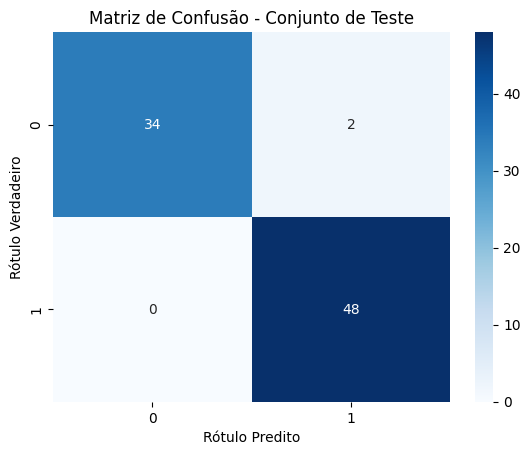


Relatório de Classificação (Conjunto de Teste):
               precision    recall  f1-score   support

NãoTremor (0)       1.00      0.94      0.97        36
   Tremor (1)       0.96      1.00      0.98        48

     accuracy                           0.98        84
    macro avg       0.98      0.97      0.98        84
 weighted avg       0.98      0.98      0.98        84


--- Validação Cruzada (no conjunto de treino escalado) ---
Acurácias da Validação Cruzada (5-fold): [1.         1.         0.98507463 0.98507463 0.96969697]
Acurácia Média da Validação Cruzada: 0.9880 (+/- 0.0113)


In [ ]:
# Esta parte só será executada se o modelo e os dados de teste existirem
if 'modelo_arvore_decisao' in locals() and 'X_teste_escalado_dados' in locals() and 'y_teste_rotulos' in locals():
    # 5. Avaliação no Conjunto de Teste
    print("\n--- Avaliação no Conjunto de Teste ---")
    y_predicoes_teste = modelo_arvore_decisao.predict(X_teste_escalado_dados)

    acuracia_teste = accuracy_score(y_teste_rotulos, y_predicoes_teste)
    print(f"Acurácia no Conjunto de Teste: {acuracia_teste:.4f}")

    matriz_confusao_resultados = confusion_matrix(y_teste_rotulos, y_predicoes_teste)

    sns.heatmap(matriz_confusao_resultados, annot=True, fmt="d", cmap="Blues",
                xticklabels=modelo_arvore_decisao.classes_, yticklabels=modelo_arvore_decisao.classes_)
    plt.xlabel("Rótulo Predito")
    plt.ylabel("Rótulo Verdadeiro")
    plt.title("Matriz de Confusão - Conjunto de Teste")
    plt.show()

    print("\nRelatório de Classificação (Conjunto de Teste):")
    # Garante que os nomes das classes correspondem aos rótulos e ordem do modelo
    nomes_classes = [f'NãoTremor ({modelo_arvore_decisao.classes_[0]})', f'Tremor ({modelo_arvore_decisao.classes_[1]})'] if len(modelo_arvore_decisao.classes_)==2 else None
    print(classification_report(y_teste_rotulos, y_predicoes_teste, target_names=nomes_classes))
else:
    print("Modelo ou dados de teste não encontrados. Por favor, execute as partes anteriores.")

# Esta parte só será executada se o modelo e os dados de treino existirem
if 'modelo_arvore_decisao' in locals() and 'X_treino_escalado_dados' in locals() and 'y_treino_rotulos' in locals():
    # 6. Validação Cruzada (no conjunto de treino escalado)
    print("\n--- Validação Cruzada (no conjunto de treino escalado) ---")
    scores_cv_acuracia = cross_val_score(modelo_arvore_decisao, X_treino_escalado_dados, y_treino_rotulos, cv=5, scoring='accuracy')
    print(f"Acurácias da Validação Cruzada (5-fold): {scores_cv_acuracia}")
    print(f"Acurácia Média da Validação Cruzada: {np.mean(scores_cv_acuracia):.4f} (+/- {np.std(scores_cv_acuracia):.4f})")
else:
    print("Modelo ou dados de treino não encontrados para validação cruzada.")

In [ ]:
# Esta parte só será executada se o modelo, scaler e nomes das features existirem
if 'modelo_arvore_decisao' in locals() and 'scaler_de_dados' in locals() and 'nomes_colunas_features' in locals():
    # 7. Exportar Parâmetros do Modelo para C/C++
    exportar_modelo_e_scaler_para_c_header(modelo_arvore_decisao, scaler_de_dados, nomes_colunas_features, CAMINHO_EXPORTAR_PARAMETROS_C)
    print("\nScript de treinamento de modelo (execução modular) concluído.")
else:
    print("Modelo, scaler ou nomes das features não definidos. Não foi possível exportar os parâmetros para C.")


--- Parâmetros do Modelo e Scaler para Implementação em C/C++ (Saída no Console) ---
Nomes das Features (Ordem): ['mean_accel_x', 'std_accel_x', 'var_accel_x', 'min_accel_x', 'max_accel_x', 'ptp_accel_x', 'energy_accel_x', 'mav_accel_x', 'mean_accel_y', 'std_accel_y', 'var_accel_y', 'min_accel_y', 'max_accel_y', 'ptp_accel_y', 'energy_accel_y', 'mav_accel_y', 'mean_accel_z', 'std_accel_z', 'var_accel_z', 'min_accel_z', 'max_accel_z', 'ptp_accel_z', 'energy_accel_z', 'mav_accel_z', 'mean_svm', 'std_svm', 'var_svm', 'min_svm', 'max_svm', 'ptp_svm', 'energy_svm', 'mav_svm']
Médias do Scaler: [ 1.02188654e+01  2.28296651e+00  1.02002389e+01  5.22562478e+00
  1.89872882e+01  1.37616634e+01  5.74088573e+03  1.02326841e+01
  2.94102176e-01  9.31166737e-01  1.66920908e+00 -1.65741119e+00
  3.62482139e+00  5.28223258e+00  8.99179683e+01  7.18459371e-01
 -2.25340990e+00  1.24075164e+00  2.92679911e+00 -6.87506484e+00
  9.11825237e-01  7.78689007e+00  4.04036775e+02  2.41622221e+00
  1.06425630e